In [1]:
# jupyter notebook --no-browser --port 8890 --ip=0.0.0.0
# local
# ssh -N -f -L localhost:8890:n-62-12-19:8890 s212645@login1.hpc.dtu.dk

In [1]:
path = '/work3/s212645/DiffusionAirfoilTransform/Airfoils/'
airfoilpath = path
name = path.split('/')[3]

from utils import *
v = 5.7
mass = 0.32
area = 0.2254
d = 0.155
thickness = 0.058
reynolds = reynolds_pipe(velocity=v, diameter=d)
_cl = mode_cl(velocity=v, area=area, mass = mass)
af = np.loadtxt('BETTER/20150114-50 +2 d.dat', skiprows=1)
af = interpolate(af, 256, 3)
vs = np.linspace(5.5, 6, 3)
mass = 0.32
area = 0.2254
d = 0.155
thickness = 0.058
perf_bl = type2_simu(af, mass, d, area)
print(perf_bl)

simlog = f'results/{name}_{int(reynolds)}_{_cl:.2f}_simlog.txt'
simperf = f'results/{name}_{int(reynolds)}_{_cl:.2f}_simperf.log'
try:
    lines = []
    with open(simperf, 'r') as fin:
        for line in fin:
            lines.append(line)
    perf_bl = float(lines[-1].split('perf: ')[-1].split(', ')[0])
    print(perf_bl)
except:
    pass

try:
    log = np.loadtxt(simlog)
    i = int(log[0])
    k = int(log[1])
    m = int(log[2])
except:
    m = 0
    i = 0
    k = 0


print(f'i: {i}, k: {k}, m: {m}')
while 1:
    num = str(i).zfill(3)
    airfoils = np.load(airfoilpath+num+'.npy')
    airfoils = delete_intersect(airfoils)
    while k < airfoils.shape[0]:
        airfoil = airfoils[k,:,:]
        airfoil = derotate(airfoil)
        airfoil = Normalize(airfoil)
        airfoil = interpolate(airfoil, 400, 3)
        xhat, yhat = savgol_filter((airfoil[:,0], airfoil[:,1]), 10, 3)
        airfoil[:,0] = xhat
        airfoil[:,1] = yhat
        airfoil[:,1] = airfoil[:,1] * thickness / cal_thickness(airfoil)
        airfoil = interpolate(airfoil, 300, 3)
        if detect_intersect(airfoil):
            perf = np.nan
        else:
            try:
                perf = type2_simu(airfoil, mass, d, area)
                successful = True
                if not np.isnan(perf):
                    print(f'perf: {perf:4f}')
            except Exception as e:
                perf = np.nan
                print(e)
        if np.isnan(perf):
            pass
        elif perf > perf_bl:
            perf_bl = perf
            mm = str(m).zfill(3)
            af_name = f'{name}_{int(reynolds)}_{_cl:.2f}_{int(mm)}'
            np.savetxt(f'samplesP5B/{af_name}.dat', airfoil, header=f'{af_name}', comments="")
            f = open(simperf, 'a')
            f.write(f'perf: {perf}, m: {mm}, path: samplesP5B/{af_name}.dat\n')
            f.close()
            m += 1
            del f
        k += 1
        log = np.array([i, k, m])
        np.savetxt(simlog, log)
        del airfoil
        gc.collect()
    k = 0
    i += 1
    del airfoils
    gc.collect()

100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


39.948841364498186
63.34465997977709
i: 20, k: 145, m: 3


  0%|          | 0/6 [00:00<?, ?it/s]

In [65]:
import sys
sys.path.append('./')
import math
from inspect import isfunction
from functools import partial

# %matplotlib inline
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from pathlib import Path
from torch.utils.data import Dataset
import torch
from torch import nn, einsum
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
import os
from networks import Unet
from Unet1D import Unet1D

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCHSIZE = 64

In [55]:
torch.cuda.is_available()
timesteps = 300

In [57]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


In [58]:
# define beta schedule
betas = cosine_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


In [59]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


In [60]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = x_noisy[0].cpu().numpy().transpose(1,2,0)

  return noisy_image


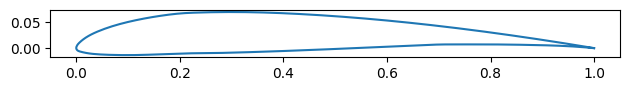

In [61]:
# take time step
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataroot = 'data/airfoil_interp.npy'
data = np.load(dataroot)
fig, axs = plt.subplots(1, 1)
axs.plot(data[0,:,0], data[0,:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

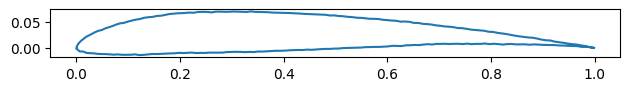

In [62]:
t = torch.tensor([5]).to(device)
noisy = torch.from_numpy(data[0,:,:]).to(device)
noisy = noisy.unsqueeze(dim=-1).unsqueeze(dim=0).permute(0,3,1,2)
noisy = get_noisy_image(noisy, t)
noisy = noisy.reshape(256, 2)

fig, axs = plt.subplots(1, 1)
axs.plot(noisy[:,0], noisy[:,1])
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

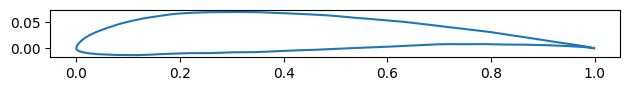

In [63]:
from scipy.signal import savgol_filter
xhat, yhat = savgol_filter((noisy[:,0], noisy[:,1]), 10, 3)

fig, axs = plt.subplots(1, 1)
axs.plot(xhat, yhat)
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()

In [77]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        loss = F.smooth_l1_loss(noise, predicted_noise) + F.mse_loss(noise, predicted_noise)

    return loss


In [79]:
from torch.utils.data import Dataset
class GetDataset(Dataset):
    def __init__(self, data, arg=True):
        self.data = data
        self.arg = arg
        self.length = data.shape[0]

    def __getitem__(self, idx):
        # return np.float32(np.expand_dims(self.data[idx,:,:], 0))
        return np.float32(self.data[idx,:,:])

    def __len__(self):
        return self.length

dataset = GetDataset(data)
train_loader = DataLoader(dataset=dataset, batch_size=128, shuffle=True)
batch = next(iter(train_loader))
print(batch.shape)

torch.Size([128, 256, 2])


In [80]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
    return img

@torch.no_grad()
def sample(model, batch_size=16, channels=1):
    return p_sample_loop(model, shape=(batch_size, channels, 256, 2))

In [68]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [88]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

# model = Unet(
#     dim=64,
#     init_dim=64,
#     out_dim=1,
#     channels=1,
#     self_condition=False,
#     dim_mults=(1, 2,)
# )
# model.to(device)
model = Unet1D(
    dim=64,
    init_dim=64,
    out_dim=1,
    channels=1,
    self_condition=False,
    dim_mults=(1, 2, 4, 8)
)
model.to(device)

channels = 1
epochs = 10000
epoch = 0
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)

In [89]:
epochs = 10000
epoch = 0
while epoch < epochs:
  losses = []
  for step, labels in enumerate(train_loader):
    labels = labels.to(device)
    labels = Variable(labels)
    batch_size = labels.shape[0]
    labels = labels.reshape(batch_size, 1, 512)
    optimizer.zero_grad()

    # Algorithm 1 line 3: sample t uniformally for every example in the batch
    t = torch.randint(0, timesteps, (batch_size,), device=device).long()

    loss = p_losses(model, labels, t, loss_type="l1+l2")
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
  print("Epoch: ", epoch, "Loss:", np.array(losses).mean(), 'lr: ', optimizer.param_groups[0]['lr'])
  epoch += 1
  scheduler.step()

In [165]:
# sample 64 images
samples = sample(model, batch_size=64, channels=1)
print(samples)

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

tensor([[[[ 0.3259, -0.0335],
          [ 0.4381,  0.0228],
          [ 0.3369, -0.0196],
          ...,
          [ 0.5829,  0.0494],
          [ 0.5801,  0.0323],
          [ 0.5433,  0.1040]]],


        [[[ 0.3770,  0.0730],
          [ 0.4740,  0.1429],
          [ 0.3408,  0.1073],
          ...,
          [ 0.2449,  0.0863],
          [ 0.2187,  0.1307],
          [ 0.1585,  0.1838]]],


        [[[ 0.8288,  0.0465],
          [ 0.8237,  0.0360],
          [ 0.8448, -0.0299],
          ...,
          [ 0.2615,  0.1019],
          [ 0.2655,  0.1118],
          [ 0.0339,  0.1641]]],


        ...,


        [[[ 0.2796,  0.1294],
          [ 0.4077,  0.0548],
          [ 0.2609,  0.0580],
          ...,
          [ 0.7829,  0.0327],
          [ 0.7523,  0.0188],
          [ 0.8187,  0.1171]]],


        [[[ 0.4623,  0.0214],
          [ 0.5455,  0.0125],
          [ 0.4878,  0.0203],
          ...,
          [ 0.3717,  0.0133],
          [ 0.4292, -0.0161],
          [ 0.3346, -0.0

torch.Size([256, 2])


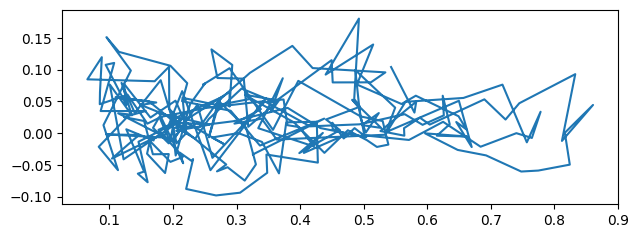

In [166]:
print(samples[0][0].shape)

fig, axs = plt.subplots(1, 1)
axs.plot(samples[0,0,:,0].cpu().numpy(), samples[0,0,:,1].cpu().numpy())
axs.set_aspect('equal', 'box')
fig.tight_layout()
plt.show()